In [118]:
from datasets import load_dataset
dataset = load_dataset("roneneldan/TinyStories")

C:\Users\chaitanyamanem\anaconda3\envs\venv_clear_text\lib\site-packages\huggingface_hub\repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2119719
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 21990
    })
})

In [56]:
subset = dataset["train"].select(range(2000))

In [1]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [6]:
def preprocess_function(examples):
    from transformers import GPT2Tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    print(len(examples["text"]))
    return tokenizer(examples["text"])

In [7]:
tokenized_subset = subset.map(
    preprocess_function,
    batched=True,
    num_proc=4,
    remove_columns=subset.column_names    
)

Map (num_proc=4):   0%|          | 0/2000 [00:00<?, ? examples/s]

In [8]:
tokenized_subset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 2000
})

In [9]:
tokenized_subset["input_ids"][0]

[3198,
 1110,
 11,
 257,
 1310,
 2576,
 3706,
 20037,
 1043,
 257,
 17598,
 287,
 607,
 2119,
 13,
 1375,
 2993,
 340,
 373,
 2408,
 284,
 711,
 351,
 340,
 780,
 340,
 373,
 7786,
 13,
 20037,
 2227,
 284,
 2648,
 262,
 17598,
 351,
 607,
 1995,
 11,
 523,
 673,
 714,
 34249,
 257,
 4936,
 319,
 607,
 10147,
 13,
 198,
 198,
 43,
 813,
 1816,
 284,
 607,
 1995,
 290,
 531,
 11,
 366,
 29252,
 11,
 314,
 1043,
 428,
 17598,
 13,
 1680,
 345,
 2648,
 340,
 351,
 502,
 290,
 34249,
 616,
 10147,
 1701,
 2332,
 1995,
 13541,
 290,
 531,
 11,
 366,
 5297,
 11,
 20037,
 11,
 356,
 460,
 2648,
 262,
 17598,
 290,
 4259,
 534,
 10147,
 526,
 198,
 198,
 41631,
 11,
 484,
 4888,
 262,
 17598,
 290,
 384,
 19103,
 262,
 4936,
 319,
 20037,
 338,
 10147,
 13,
 632,
 373,
 407,
 2408,
 329,
 606,
 780,
 484,
 547,
 7373,
 290,
 5742,
 1123,
 584,
 13,
 2293,
 484,
 5201,
 11,
 20037,
 26280,
 607,
 1995,
 329,
 7373,
 262,
 17598,
 290,
 18682,
 607,
 10147,
 13,
 1119,
 1111,
 2936,
 3772,
 780,

In [22]:
def add_eos_token(examples):
    from transformers import GPT2Tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")    
    return {'input_ids':[x + [tokenizer.eos_token_id,] for x in examples["input_ids"]]}
    

In [23]:
tokenized_subset_processed = tokenized_subset.map(
    add_eos_token,
    batched=True,
    num_proc=1,
    remove_columns=tokenized_subset.column_names
    
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [24]:
tokenized_subset_processed

Dataset({
    features: ['input_ids'],
    num_rows: 2000
})

In [38]:
tokenized_subset_processed

Dataset({
    features: ['input_ids'],
    num_rows: 2000
})

In [45]:

def combine_split(examples):
    total_merged = [token for example in examples["input_ids"] for token in example]
    idx = 0
    block_size = 256
    inputs = []
    targets = []
    print(len(total_merged))
    while idx < len(total_merged) - block_size:
        chunk = total_merged[idx : idx+block_size+1]
        inputs.append(chunk[:-1])
        targets.append(chunk[1:])
        idx += block_size
    return {"inputs":inputs, "targets":targets}
        

In [46]:
chunked = tokenized_subset_processed.map(
    combine_split,
    batched=True,
    num_proc=1,
    remove_columns=tokenized_subset_processed.column_names
    
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

235420
184035


In [47]:
chunked

Dataset({
    features: ['inputs', 'targets'],
    num_rows: 1637
})

In [52]:
len(chunked['targets'][-1])

256

### Cleanedup code

In [55]:
def process(examples):
    from transformers import GPT2Tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    block_size = 256
    idx = 0 
    inputs, targets = [],[]
    
    
    tokenized_examples = tokenizer(examples["text"])["input_ids"]
    merged_text = [token for example in tokenized_examples for token in example+[tokenizer.eos_token_id,]]
    
    while idx < len(merged_text)-block_size:
        chunk = merged_text[idx:idx+block_size+1]
        inputs.append(chunk[:-1])
        targets.append(chunk[1:])
        idx += block_size
    return {"inputs":inputs, "targets":targets}
        
    
        

In [57]:
tokenized_subset = subset.map(
    process,
    batched=True,
    num_proc=4,
    remove_columns=subset.column_names    
)

Map (num_proc=4):   0%|          | 0/2000 [00:00<?, ? examples/s]

In [58]:
tokenized_subset

Dataset({
    features: ['inputs', 'targets'],
    num_rows: 1637
})

In [78]:
len(tokenized_subset["inputs"][1])

256

In [60]:
tokenizer.decode(tokenized_subset["inputs"][0])

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.<|endoftext|>Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leaves 

In [62]:
subset["text"][0]

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'

# Test with pytorch 

In [79]:
from torch.utils.data import DataLoader

In [82]:
tokenized_subset.set_format(type='torch', columns=['inputs', 'targets'], )

In [83]:
train_loader = DataLoader(tokenized_subset, batch_size=64)

In [87]:
for batch in train_loader:
    print(batch['inputs'].shape)
    break

torch.Size([64, 256])


In [ ]:
train_loader

In [92]:
import torch
nn = torch.nn.Linear(256,2)
for batch in train_loader:
    logits = nn(batch['inputs'].type(torch.float))
    break

In [93]:
logits.shape

torch.Size([64, 2])

## Final scaledup code

In [33]:
from datasets import load_dataset, load_from_disk
from torch.utils.data import DataLoader

from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

def process_rows_func(examples, block_size, tokenizer):     
    idx = 0 
    inputs, targets = [],[]
    
    
    tokenized_examples = tokenizer(examples["text"])["input_ids"]
    merged_text = [token for example in tokenized_examples for token in example+[tokenizer.eos_token_id,]]
    
    while idx < len(merged_text)-block_size:
        chunk = merged_text[idx:idx+block_size+1]
        inputs.append(chunk[:-1])
        targets.append(chunk[1:])
        idx += block_size
    return {"inputs":inputs, "targets":targets}



def getTrainDataLoader(batch_size = 64, block_size = 256, from_disk=False, 
                       path=None, subset_size=-1, save_to_disk=False, save_path=None):
    if from_disk:
        if path is None:
            raise Exception("To load the dataset from disk, you need to give valid path")
        reloaded_dataset = load_from_disk(path).with_format("torch")
        train_loader = DataLoader(reloaded_dataset, batch_size=batch_size)
        return reloaded_dataset, train_loader
    else:
        dataset = load_dataset("roneneldan/TinyStories")
        dataset = dataset["train"]
        if subset_size != -1:
            if subset_size <=0: 
                raise Exception("sample size should be a positive number larger than zero")
            dataset = dataset.select(range(subset_size))
        
        dataset = dataset.map(
            process_rows_func,
            fn_kwargs={'block_size':block_size, 'tokenizer':tokenizer},
            batched=True,
            num_proc=4,
            remove_columns=dataset.column_names    
        )
        
        if save_to_disk:
            if save_path is None: raise Exception("save path can't be None")
            dataset.save_to_disk(save_path)
            
        dataset.set_format(type='torch', columns=dataset.column_names)
        train_loader = DataLoader(dataset, batch_size=batch_size)
        
    
        
        return dataset, train_loader  
    
    

def getValDataLoader(batch_size = 64, block_size = 256, from_disk=False, 
                       path=None, subset_size=-1, save_to_disk=False, save_path=None):
    if from_disk:
        if path is None:
            raise Exception("To load the dataset from disk, you need to give valid path")
        reloaded_dataset = load_from_disk(path).with_format("torch")
        val_loader = DataLoader(reloaded_dataset, batch_size=batch_size)
        return reloaded_dataset, val_loader
    else:
        dataset = load_dataset("roneneldan/TinyStories")
        dataset = dataset["validation"]
        if subset_size != -1:
            if subset_size <=0: 
                raise Exception("sample size should be a positive number larger than zero")
            dataset = dataset.select(range(subset_size))
        
        dataset = dataset.map(
            process_rows_func,
            fn_kwargs={'block_size':block_size, 'tokenizer':tokenizer},
            batched=True,
            num_proc=4,
            remove_columns=dataset.column_names    
        )
        
        if save_to_disk:
            if save_path is None: raise Exception("save path can't be None")
            dataset.save_to_disk(save_path)
            
        dataset.set_format(type='torch', columns=dataset.column_names)
        val_loader = DataLoader(dataset, batch_size=batch_size)
        
    
        
        return dataset, val_loader  
    


In [25]:
train_dataset, train_loader   = getTrainDataLoader(subset_size=2000, save_to_disk=True, save_path="saved_artifacts/datasets/train_data")

Saving the dataset (0/1 shards):   0%|          | 0/1637 [00:00<?, ? examples/s]

In [26]:
train_dataset

Dataset({
    features: ['inputs', 'targets'],
    num_rows: 1637
})

In [34]:
r_train_dataset, r_train_loader   = getTrainDataLoader(from_disk=True, path="saved_artifacts/datasets/train_data")

In [35]:
r_train_dataset

Dataset({
    features: ['inputs', 'targets'],
    num_rows: 1637
})

In [31]:
import torch
nn = torch.nn.Linear(256,2)
for batch in train_loader:
    logits = nn(batch['inputs'].type(torch.float))
    break
print(logits.shape)    

torch.Size([64, 2])


In [36]:
import torch
nn = torch.nn.Linear(256,2)
for batch in r_train_loader:
    logits = nn(batch['inputs'].type(torch.float))
    break
print(logits.shape) 

torch.Size([64, 2])


In [37]:
tokenizer.vocab_size

50257

In [38]:
from tinystories_dataset import getTrainDataLoader, getValDataLoader, getVocabSize
_, train_data_loader = getTrainDataLoader(subset_size=2000)
_, val_data_loader = getValDataLoader(subset_size=1000)  

C:\Users\chaitanyamanem\anaconda3\envs\venv_clear_text\lib\site-packages\huggingface_hub\repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [47]:
for batch in train_data_loader:
    print(batch)
    break

{'inputs': tensor([[ 3198,  1110,    11,  ...,  1355,   538, 10357],
        [  739,   262,  5509,  ...,   290,   531,    11],
        [  366, 10449,   345,  ...,   673,   373,   257],
        ...,
        [ 2576, 45236,    13,  ...,   339,  2982,   257],
        [ 7838,    11,   340,  ..., 14028,  1521,   290],
        [ 1965,   607,  9955,  ...,   477,   286,   257]]), 'targets': tensor([[ 1110,    11,   257,  ...,   538, 10357,   739],
        [  262,  5509,   290,  ...,   531,    11,   366],
        [10449,   345,    11,  ...,   373,   257,  2968],
        ...,
        [45236,    13,   198,  ...,  2982,   257,  7838],
        [   11,   340,   373,  ...,  1521,   290,  1965],
        [  607,  9955,    11,  ...,   286,   257,  4802]])}


In [27]:
total_merged = [token for example in tokenized_subset_processed["input_ids"] for token in example]

In [31]:

idx = 0
chunk = total_merged[idx:idx+block_size+1]
len(chunk)

257

In [39]:
len(tokenized_subset["input_ids"][0])

162

In [31]:
subset["text"]

['One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.',
 'Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leaves that we

In [10]:
def chunk_examples(examples):
    chunks = []
    for sentence in examples["sentence1"]:
        chunks += [sentence[i:i + 50] for i in range(0, len(sentence), 50)]
    return {"chunks": chunks}

In [ ]:
chunked_dataset = dataset.map(chunk_examples, batched=True, remove_columns=dataset.column_names)
chunked_dataset[:10]

In [47]:
tokenizer.eos_token

'<|endoftext|>'

In [69]:
type(tokenizer.eos_token_id)

int

In [2]:
import torch
from torch import nn
from model import Model

from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [2]:
vocab_size = tokenizer.vocab_size
embedding_dim = 384
block_size = 256
n_heads = 6
head_size = embedding_dim // n_heads
n_blocks = 6
model = Model(vocab_size, embedding_dim, block_size, head_size, n_heads, n_blocks).to("cuda")

In [5]:
#with torch.no_grad():

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

X = torch.randint(low=0, high = vocab_size, size = (16,256)).to("cuda")
y = torch.randint(low=0, high = vocab_size, size = (16,256)).to("cuda")
pred = model(X)
loss = loss_fn(torch.permute(pred, (0,-1,-2)), y)
loss.backward()
optimizer.step()
optimizer.zero_grad()

In [4]:
pred.shape

torch.Size([16, 256, 50257])

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.eos_token_id

50256

### Generation

In [1]:
import torch
import torch.nn.functional as F
import argparse
import tqdm.notebook as tqdm
import os
import pickle
#from transformers import GPT2Tokenizer
import sentencepiece as spm


model = torch.load("saved_artifacts/models/Llama_v1/llamav1.pt")
tokenizer = spm.SentencePieceProcessor(model_file='saved_artifacts/tokenizers/tok_4096.model')
max_new_tokens=500
prompt="""Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to \
share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. \
Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then \
she makes a face. The soup is"""

prompt = """One day, Lily met a Shoggoth"""

prompt = """ Once upon a time there was a little girl named Lucy. She was very adventurous. She loved to explore the
world around her, especially when it was bright and sunny outside.
One day, while exploring the nearby park, Lucy came across a ladder leaning on a wall. She was curious
to see what’s on top, so she climbed the ladder, but when she reached the top, the ladder fell and she was
stuck.
A nearby park ranger noticed her and shouted out, ” """

prompt = """ Once upon a time there was a pumpkin. It was a very special pumpkin, it could speak. It was sad because
it couldn’t move. Every day, it would say"""

prompt = """Alice was so tired when she got back home so she went"""

def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (vocabulary size)
            top_k >0: keep only top k tokens with highest probability (top-k filtering).
            top_p >0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
        
        Basic outline taken from https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317
    """
    assert logits.dim() == 2  # [BATCH_SIZE, VOCAB_SIZE]
    top_k = min(top_k, logits.size(-1))  # Safety check
    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k, dim=1)[0][..., -1, None]
        logits[indices_to_remove] = filter_value
    
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    
    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
    # Remove tokens with cumulative probability above the threshold
    sorted_indices_to_remove = cumulative_probs > top_p
    # Shift the indices to the right to keep also the first token above the threshold
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0
    
    # Replace logits to be removed with -inf in the sorted_logits
    sorted_logits[sorted_indices_to_remove] = filter_value
    # Then reverse the sorting process by mapping back sorted_logits to their original position
    logits = torch.gather(sorted_logits, 1, sorted_indices.argsort(-1))
    return logits


def generate(model, tokenizer, max_new_tokens, prompt, block_size, temperature=0.5, top_k=0, top_p=0.8):
    idx = torch.tensor(tokenizer.encode([prompt]), dtype=torch.long).to("cuda")
    t = 0

    gen_loop = tqdm.tqdm(total=max_new_tokens, desc="gen_progress")
    while t <= max_new_tokens and int(idx[:,-1].item()) != int(tokenizer.bos_id()):
        prompt = idx[:,-block_size:]
        pred = model(prompt)
        logits = pred[:,-1,:]
        
        if temperature == 0.0:
            # "sample" the single most likely index
            _, idx_next = torch.topk(logits, k=1, dim=-1)
        else:
            # pluck the logits at the final step and scale by desired temperature
            logits = logits / temperature
            
        #logits = top_k_top_p_filtering(logits, top_p=top_p, top_k=top_k)

        
        logits = torch.softmax(logits, axis=-1)
        next_idx = torch.multinomial(logits, num_samples=1)        
        idx = torch.cat([idx, next_idx], axis=1)
        t += 1
        gen_loop.update(1)        
    
    
    generated_text = tokenizer.decode(idx.to("cpu").numpy().tolist())
    gen_loop.write("\n###############################")
    print(generated_text[0])
    gen_loop.write("\n###############################")




generate(model, tokenizer, max_new_tokens, prompt, 1024, temperature=0.2)




AttributeError: Can't get attribute 'Config' on <module '__main__'>

In [34]:
print(tokenizer.decode(idx.to("cpu").numpy().tolist()))

Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is pink. She does not have to drink it. Yuck! Yuck! It is sweet, not so good!"

Tom and Jane think it is difficult. They must help Jane to make more soup. They sit down on a small table and drink their soup recipe. They put their plates around the table and add some salt. They finish their soup. Then they hug each other and say goodbye. They decide to play to learn from the butterfly dance. They both think it was a very interesting day.


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [12]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

model = AutoModelForCausalLM.from_pretrained('roneneldan/TinyStories-33M')

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")

#prompt = "Once upon a time there was"

input_ids = tokenizer.encode(prompt, return_tensors="pt")

#Generate completion
output = model.generate(input_ids, max_length = 1000, num_beams=1)

#Decode the completion
output_text = tokenizer.decode(output[0], skip_special_tokens=True)

#Print the generated text
print(output_text)



config.json:   0%|          | 0.00/968 [00:00<?, ?B/s]

C:\Users\chaitanyamanem\anaconda3\envs\venv_clear_text\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\chaitanyamanem\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/291M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is bitter! Jane does not like it. She makes a face too.

Tom and Jane look at each other. They both laugh. Tom says, “Let’s try something else.” Jane nods. They both look for something else to eat. They see some apples in the kitchen. They both pick one and start to eat it. It is sweet and juicy. They both enjoy it.

Tom and Jane are happy. They have learned a lesson. They will always try new things. They will always remember to share.



In [13]:
model

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-3): 4 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_feat

In [21]:
len(tokenizer(dataset["train"]["text"][0])["input_ids"])


162

In [ ]:
def get_lengths()

In [16]:
64 * 256 * 50000 * 32 * 1e-10

2.62144

In [17]:
from tinystories_dataset import getTrainDataLoader, getValDataLoader, getVocabSize

In [19]:
%%time
_, train_data_loader = getTrainDataLoader(batch_size=8,block_size=512, save_to_disk=True, save_path="saved_artifacts/datasets/train_data")
_, val_data_loader = getValDataLoader(batch_size=8, block_size=512, save_to_disk=True, save_path="saved_artifacts/datasets/val_data")  

Map (num_proc=4):   0%|          | 0/2119719 [00:00<?, ? examples/s]

Saving the dataset (0/16 shards):   0%|          | 0/924712 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/21990 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9296 [00:00<?, ? examples/s]

CPU times: total: 14.7 s
Wall time: 15min 40s


In [22]:
class AverageMeter:
    def __init__(self, name):
        self.name = name
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
    def __str__(self):
        return f"{self.name}: {self.avg}"

In [24]:
loss = AverageMeter("val_loss")


val_loss: 3.0


In [28]:
loss.update(0.2, 16)
print(loss)

val_loss: 1.8399999999999999


In [32]:
type(float("inf"))

float

### Loss curves

In [36]:
with open('saved_artifacts/models/test_model/loss_data.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [37]:
loaded_dict

{'train_loss': [10.924073219299316, 9.671029567718506, 8.939854939778646],
 'val_loss': [10.924189423376433, 8.559734096577692, 7.340456433890669]}

### Validation Data Loss

In [27]:
from tinystories_dataset import getTrainDataLoader, getValDataLoader, getVocabSize
from torch import nn

In [22]:
model = torch.load("saved_artifacts/models/model_v1/model1.pt")

In [28]:
_, val_data_loader = getValDataLoader(4, from_disk=True,
                                      path="saved_artifacts/datasets/val_data")

In [29]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    val_loss = []  
    num_batches = len(dataloader)       
    
    for i, data in enumerate(dataloader):        
        X,y = data["inputs"].to(device), data["targets"].to(device)
        pred = model(X)
        loss = loss_fn(torch.permute(pred,(0,-1,-2)), y)
        val_loss.append(loss.item())        
    return val_loss

In [32]:
loss_fn = nn.CrossEntropyLoss()
device = 'cuda'

In [33]:
val_loss = test_loop(val_data_loader, model, loss_fn)

In [35]:
sum(val_loss) / len(val_loss)

1.7232683165040565

## Training the custom tokenizer

In [42]:
## Save the entire stories into single text file
import os
from tqdm.notebook import trange, tqdm
from datasets import load_dataset
dataset = load_dataset("roneneldan/TinyStories")

C:\Users\chaitanyamanem\anaconda3\envs\venv_clear_text\lib\site-packages\huggingface_hub\repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [37]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2119719
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 21990
    })
})

In [43]:
total_text_file = os.path.join("saved_artifacts","datasets","total_text.txt")
with open(total_text_file, "w", encoding="utf-8") as f:
    for row in tqdm(dataset["train"]):
        f.write(row["text"].strip() + '\n')
        

  0%|          | 0/2119719 [00:00<?, ?it/s]

### Train the tokinizer

In [47]:
import sentencepiece as spm

In [49]:
vocab_size = 4096
prefix = os.path.join("saved_artifacts","tokenizers",f"tok_{vocab_size}")
prefix

'saved_artifacts\\tokenizers\\tok_4096'

In [50]:
spm.SentencePieceTrainer.train(input=total_text_file,
                                   model_prefix=prefix,
                                   model_type="bpe",
                                   vocab_size=vocab_size,
                                   self_test_sample_size=0,
                                   input_format="text",
                                   character_coverage=1.0,
                                   num_threads=os.cpu_count(),
                                   split_digits=True,
                                   allow_whitespace_only_pieces=True,
                                   byte_fallback=True,
                                   unk_surface=r" \342\201\207 ",
                                   normalization_rule_name="identity")

In [57]:
from tokenizer import Tokenizer

ModuleNotFoundError: No module named 'tokenizer'

In [77]:
tokenizer_model = "saved_artifacts/tokenizers/tok_4096.model"

In [78]:
tokenizer = spm.SentencePieceProcessor(model_file=tokenizer_model)

In [79]:
encoder.vocab_size()

4096

In [70]:
encoder.encode(["hello world","How are you voing"],add_bos=True)

[[1, 2042, 1262], [1, 2189, 442, 350, 1047, 292]]

In [72]:
encoder.decode([[292]])

['ing']

In [168]:
512 / 8

64.0

In [15]:
tokenizer.decode([[1, 2042, 1262], [1, 2189, 442, 350, 1047, 292]])

['hello world', 'How are you voing']

## pretokenizer test

In [140]:
from datasets import load_dataset, load_from_disk
from torch.utils.data import DataLoader
import sentencepiece as spm
import os


class TinyStories:
    def __init__(self, vocab_size, context_length, tokenizers_path):
        self.vocab_size = vocab_size
        self.context_length = context_length
        self.tokenizer_model_path = os.path.join(tokenizers_path,f"tok_{vocab_size}.model")
        self.tokenizer = spm.SentencePieceProcessor(model_file=self.tokenizer_model_path)

    
    def process_rows_func(self,examples, context_length):     
        idx = 0 
        inputs, targets = [],[]
        
        
        tokenized_examples = self.tokenizer.encode(examples["text"], add_bos=True)
        merged_text = [token for example in tokenized_examples for token in example]
        
        while idx < len(merged_text)-context_length:
            chunk = merged_text[idx:idx+context_length+1]
            inputs.append(chunk[:-1])
            targets.append(chunk[1:])
            idx += context_length
        return {"inputs":inputs, "targets":targets}



    def getTrainDataLoader(self, batch_size = 64, context_length = 256, from_disk=False, 
                        path=None, subset_size=-1, save_to_disk=False, save_path=None):
        if from_disk:
            if path is None:
                raise Exception("To load the dataset from disk, you need to give valid path")
            reloaded_dataset = load_from_disk(path).with_format("torch")
            train_loader = DataLoader(reloaded_dataset, batch_size=batch_size)
            return reloaded_dataset, train_loader
        else:
            dataset = load_dataset("roneneldan/TinyStories")
            dataset = dataset["train"]
            if subset_size != -1:
                if subset_size <=0: 
                    raise Exception("sample size should be a positive number larger than zero")
                dataset = dataset.select(range(subset_size))
            
            dataset = dataset.map(
                self.process_rows_func,
                fn_kwargs={'context_length':context_length},
                batched=True,
                num_proc=4,
                remove_columns=dataset.column_names    
            )
            
            if save_to_disk:
                if save_path is None: raise Exception("save path can't be None")
                dataset.save_to_disk(save_path)
                
            dataset.set_format(type='torch', columns=dataset.column_names)
            train_loader = DataLoader(dataset, batch_size=batch_size)
            
        
            
            return dataset, train_loader  
    
    

    def getValDataLoader(self, batch_size = 64, context_length = 256, from_disk=False, 
                        path=None, subset_size=-1, save_to_disk=False, save_path=None):
        if from_disk:
            if path is None:
                raise Exception("To load the dataset from disk, you need to give valid path")
            reloaded_dataset = load_from_disk(path).with_format("torch")
            val_loader = DataLoader(reloaded_dataset, batch_size=batch_size)
            return reloaded_dataset, val_loader
        else:
            dataset = load_dataset("roneneldan/TinyStories")
            dataset = dataset["validation"]
            if subset_size != -1:
                if subset_size <=0: 
                    raise Exception("sample size should be a positive number larger than zero")
                dataset = dataset.select(range(subset_size))
            
            dataset = dataset.map(
                self.process_rows_func,
                fn_kwargs={'context_length':context_length},
                batched=True,
                num_proc=4,
                remove_columns=dataset.column_names    
            )
            
            if save_to_disk:
                if save_path is None: raise Exception("save path can't be None")
                dataset.save_to_disk(save_path)
                
            dataset.set_format(type='torch', columns=dataset.column_names)
            val_loader = DataLoader(dataset, batch_size=batch_size) 
        
            return dataset, val_loader
        
    def getVocabSize(self):
        return int(self.tokenizer.vocab_size)
    




In [141]:
tiny_stories = TinyStories(tokenizer.vocab_size(), 1024, "saved_artifacts/tokenizers")

In [142]:
_, train_data_loader = tiny_stories.getTrainDataLoader(batch_size=64, context_length=1024, subset_size=1000)

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [151]:
train_iterator = iter(train_data_loader)

In [157]:
def getBatch():    
    try:
        batch = next(train_iterator)
    except:
        train_iterator = iter(train_data_loader)
        batch = next(train_iterator)
    return batch
    

In [159]:
for i in range(5):
    print(getBatch())
    

{'inputs': tensor([[   1,  422,  361,  ...,  397,  288,  773],
        [2259,  320,  265,  ...,  791,  573,  362],
        [ 361,  348, 3968,  ...,  365,  874,  351],
        ...,
        [ 744, 3960,  315,  ..., 3955,  742,  285],
        [ 354,  407,  267,  ...,  351, 2667,  320],
        [ 356, 2646,  267,  ...,  310,  934, 3974]]), 'targets': tensor([[ 422,  361, 3968,  ...,  288,  773, 2259],
        [ 320,  265,  739,  ...,  573,  362,  361],
        [ 348, 3968,  367,  ...,  874,  351,  493],
        ...,
        [3960,  315, 1216,  ...,  742,  285,  354],
        [ 407,  267, 2007,  ..., 2667,  320,  356],
        [2646,  267, 1199,  ...,  934, 3974, 3954]])}
{'inputs': tensor([[   1,  422,  361,  ...,  397,  288,  773],
        [2259,  320,  265,  ...,  791,  573,  362],
        [ 361,  348, 3968,  ...,  365,  874,  351],
        ...,
        [ 744, 3960,  315,  ..., 3955,  742,  285],
        [ 354,  407,  267,  ...,  351, 2667,  320],
        [ 356, 2646,  267,  ...,  310,  

In [122]:
def process_rows_func(examples, context_length):     
    idx = 0 
    inputs, targets = [],[]


    tokenized_examples = tokenizer.encode(examples["text"], add_bos=True)
    merged_text = [token for example in tokenized_examples for token in example]

    while idx < len(merged_text)-context_length:
        chunk = merged_text[idx:idx+context_length+1]
        inputs.append(chunk[:-1])
        targets.append(chunk[1:])
        idx += context_length
    return {"inputs":inputs, "targets":targets}

In [98]:
lens = []
for example in dataset["train"][:10]["text"]:
    lens.append(len(tokenizer.encode(example, add_bos=True)))
    

In [99]:
lens, sum(lens)

([169, 186, 219, 206, 168, 179, 174, 189, 203, 159], 1852)

In [126]:
dataset["train"][:10]["text"][0]

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'

In [127]:
1842 / 512

3.59765625

In [128]:
datasetn = dataset["train"].select(range(10))
datasetnn = datasetn.map(process_rows_func, fn_kwargs={'context_length':512}, batched=True)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

ArrowInvalid: Column 1 named inputs expected length 10 but got length 3

In [110]:
len(merged_text)

1852

In [111]:
len(dataset["inputs"])

3

In [114]:
#dataset.set_format(type='torch', columns=dataset.column_names)
train_loader = DataLoader(dataset, batch_size=2)

In [115]:
for idx, batch in enumerate(train_loader):
    print(idx)

KeyError: 0

In [103]:
1024 * 4 * x = 100000

4096

In [104]:
100000 / (1024 * 4)

24.4140625

In [105]:
200000 * 16

3200000

In [106]:
3200000 / 4

800000.0

In [160]:
1024 * 25

25600

In [165]:
100000 / 16384

6.103515625

In [164]:
16 * 1024

16384

In [172]:
1024 * 4 * 32

131072

In [173]:
1000000

1000000

In [177]:
1e-6

1e-06

In [179]:
29930496 * 1e-6

29.930495999999998

In [4]:
3 * 10e7 * 32 * 1.25e-10

1.2000000000000002

# RoPE Comparison Statistics

In [1]:
import pickle
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt
save_root_directory = "saved_artifacts/models/model_v4"
history_file_path = os.path.join(save_root_directory,"loss_data.pkl")
with open(history_file_path, 'rb') as handle:
    history = pickle.load(handle)
print(f"Final validtion loss of the model: {history['val_loss'][-1]}")

Final validtion loss of the model: 1.4031831032935418


In [2]:
model_path = os.path.join(save_root_directory, "model4.pt")
model = torch.load(model_path)
model

AttributeError: Can't get attribute 'Block' on <module 'model' from 'C:\\A_DATA\\E\\AI\\usecases\\TinyStories\\model.py'>

In [15]:
poe = model.position_embedding.weight

In [16]:
from torch import nn
class Config:
    head_size = 128
    seq_len = 1024
    
config = Config()
    
class RoPE(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.cos_mthetas = None
        self.sin_mthetas = None
        self.__set_thetas()
        
    def __set_thetas(self):
        """This sets the parameters of the rope as per the formula
        Θ = {θi = 10000−2(i−1)/d, i ∈ [1, 2, ..., d/2]}
        """
        assert self.config.head_size % 2 == 0, f"Head size:{self.config.head_size} shouls be even number"
        self.d = self.config.head_size
        self.m = self.config.seq_len
        
        i_s = torch.tensor(range(1,self.d//2+1))
        i_s = torch.cat([i_s,i_s], axis=-1)
        m_s = torch.tensor(range(self.m)).unsqueeze(axis=-1)
        
        thetas = 10000 ** (-2*(i_s-1)/self.d)
        self.cos_mthetas = torch.cos(m_s * thetas)
        self.sin_mthetas = torch.sin(m_s * thetas)
        
    def forward(self, x):
        """ assumes x in the format of """
        d  = x.shape[-1]
        
        assert d == self.d
        
        x = self.cos_mthetas * x + self.sin_mthetas * torch.cat([-1 * x[:,:,:,self.d//2:],x[:,:,:,:self.d//2]], axis=-1)
        return x

In [17]:
512 / 8

64.0

In [18]:
ROPE = RoPE(config)
x = torch.ones(1,8,1024,128)
rope = ROPE(x)
rope = rope.squeeze(axis=0)

In [23]:
rope.shape, poe.shape

(torch.Size([8, 1024, 128]), torch.Size([1024, 512]))

In [25]:
rope.ndim

3

In [26]:
import random

seq_len = 1024

def get_attention_values(poe, seq_len, start_pos = 0, position_offset = -1):
    attention_values = []
    
    if position_offset == -1:
        samples = 1000
        for _ in range(samples):
            iq = random.randint(start_pos, seq_len-1)
            ik = random.randint(start_pos, seq_len-1)
            attention_values.append((poe[iq] @ poe[ik]).item())            
    else:
        if poe.ndim == 3:
            poe = poe[0,:,:]
        while start_pos + position_offset < seq_len:
            attention_values.append((poe[start_pos] @ poe[start_pos + position_offset]).item())        
            start_pos += 1
    return attention_values

In [27]:
attention_values_1 = get_attention_values(poe,seq_len, position_offset=1)
# attention_values_3 = get_attention_values(poe,seq_len, position_offset=3)
attention_values_50 = get_attention_values(poe,seq_len, position_offset=50)
#attention_values_rand_offset = get_attention_values(poe,seq_len, position_offset=-1)

attention_values_rope_1 = get_attention_values(rope, 1024, position_offset=1)
# attention_values_rope_3 = get_attention_values(rope, 1024, position_offset=3)
# attention_values_rope_5 = get_attention_values(rope, 1024, position_offset=5)
# attention_values_rope_10 = get_attention_values(rope, 1024, position_offset=10)
# attention_values_rope_15 = get_attention_values(rope, 1024, position_offset=15)
# attention_values_rope_20 = get_attention_values(rope, 1024, position_offset=20)
# attention_values_rope_30 = get_attention_values(rope, 1024, position_offset=30)
# attention_values_rope_40 = get_attention_values(rope, 1024, position_offset=40)
#attention_values_rand_offset_rope = get_attention_values(rope, 1024, position_offset=-1)

In [65]:
np.mean(attention_values_rope_1), np.mean(attention_values_rope_3), np.mean(attention_values_rope_5), np.mean(attention_values_rope_10), np.mean(attention_values_rope_15), np.mean(attention_values_rope_20), np.mean(attention_values_rope_30), np.mean(attention_values_rope_40)

(30.62729852476894,
 24.54479637855881,
 23.55476579862675,
 20.117853399799657,
 16.812139702032294,
 20.94170736411653,
 15.228713215956505,
 15.579402344013618)

Mean Attention: 5.179224010553295, Standard deviaiton is: 13.53436903795924


C:\Users\chaitanyamanem\AppData\Local\Temp\ipykernel_13476\3298735368.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=attention_values_1,  color = 'red')


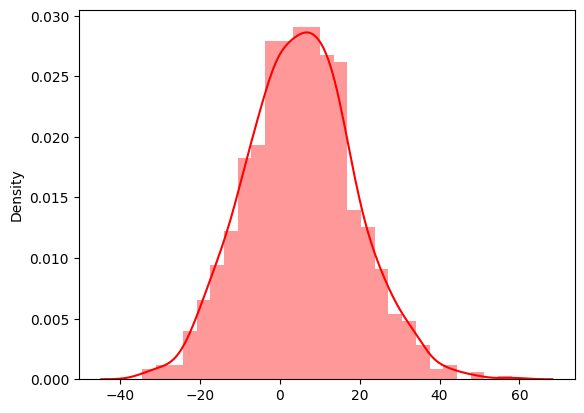

PE: Attention values for positions with offset 1


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



print(f"Mean Attention: {np.mean(attention_values_1)}, Standard deviaiton is: {np.std(attention_values_1)}")
# print(f"Standard deviaiton is: {np.std(attention_values_rand_offset)}")


sns.distplot(x=attention_values_1,  color = 'red')
plt.savefig("generated_texts/pe1.svg")
plt.show()
# sns.displot(x=attention_values_rand_offset,  color = 'blue')
# plt.show()
print("PE: Attention values for positions with offset 1")

Mean Attention: 124.18736745884691, Standard deviaiton is: 3.8199218471163054e-05


C:\Users\chaitanyamanem\AppData\Local\Temp\ipykernel_13476\2736676096.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=attention_values_rope_1, color = 'darkblue')


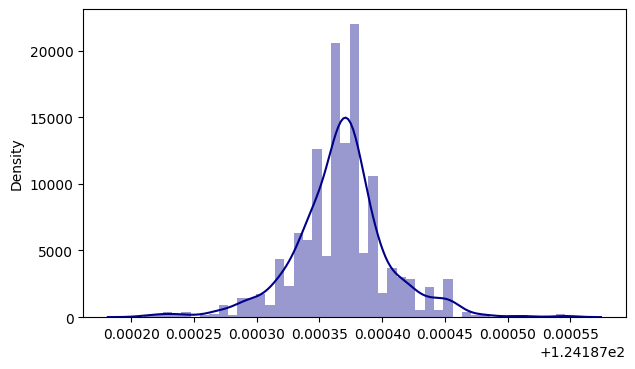

RoPE: Attention values for positions with offset 1


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
print(f"Mean Attention: {np.mean(attention_values_rope_1)}, Standard deviaiton is: {np.std(attention_values_rope_1)}")
#print(f"Mean Attention: {np.mean(attention_values_rand_offset_rope)}, Standard deviaiton is: {np.std(attention_values_rand_offset_rope)}")

plt.figure(figsize=(7,4))
sns.distplot(x=attention_values_rope_1, color = 'darkblue')
plt.savefig("generated_texts/rope1.svg")
plt.show()
print("RoPE: Attention values for positions with offset 1")
# sns.displot(x=attention_values_rand_offset_rope,  color = 'blue')
# plt.show()

## Trend Analysis

In [58]:
offset_max = 100
attention_values_1_mean_trend, attention_values_rope_1_mean_trend = [],[]
for f in range(offset_max):
    attention_values_1_mean_trend.append(np.mean(get_attention_values(poe,seq_len, position_offset=f+1)))
    attention_values_rope_1_mean_trend.append(np.mean(get_attention_values(rope, 1024, position_offset=f+1)))

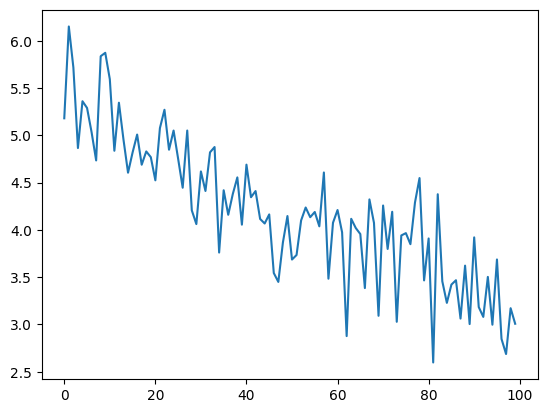

In [59]:
sns.lineplot(x=list(range(len(attention_values_1_mean_trend))), y=attention_values_1_mean_trend)
plt.show()

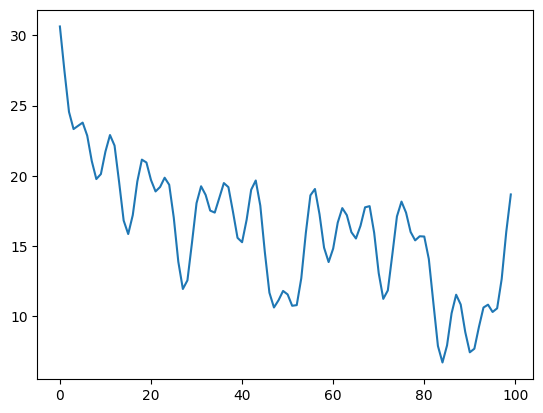

In [60]:
sns.lineplot(x=list(range(len(attention_values_rope_1_mean_trend))), y=attention_values_rope_1_mean_trend)
plt.show()

In [ ]:
import random

seq_len = 1024

def get_attention_values(poe, seq_len, pos = 0):
    attention_values = []
    for iq in range(seq_len):
        position_att_values = []
        for ik in range(seq_len):
            position_att_values.append((poe[iq] @ poe[ik]).item())
        attention_values.append(position_att_values)

In [106]:
attention_values = rope @ torch.transpose(rope,-2,-1)

In [107]:
attention_values.shape

torch.Size([8, 1024, 1024])

In [108]:
import numpy as np
def moving_average(x, w):
    end = x.shape[0]
    ans = np.ones_like(x)
    
    for pos in range(end):
        left = max(pos - w,0)
        right = min(pos + w + 1, end)
        ans[pos] = np.mean(x[left:pos].tolist() + x[pos:right].tolist())
        
    return ans

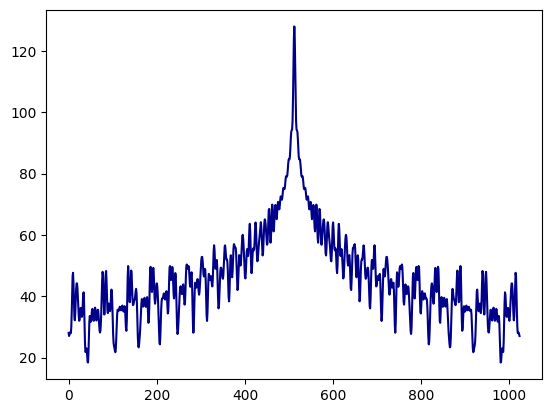

In [109]:
#sns.lineplot(x=range(1024), y=moving_average(attention_values.numpy()[0,512,:], 100))
sns.lineplot(x=range(1024), y=attention_values.numpy()[0,512,:], color='darkblue')
plt.savefig("generated_texts/1word_attn_graph_rope_e128.svg")
plt.show()


In [111]:
attention_values_vanilla = poe @ torch.transpose(poe,0,1)
attention_values_vanilla.shape

torch.Size([1024, 1024])

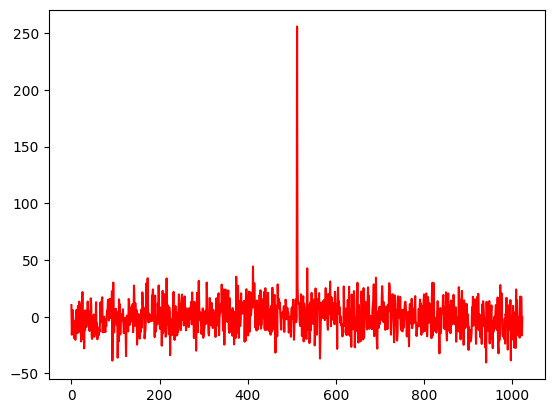

In [115]:
sns.lineplot(x=range(1024), y=attention_values_vanilla.to("cpu").detach().numpy()[512,:], color='red')
plt.savefig("generated_texts/1word_attn_graph_pe_e512.svg")
plt.show()
#plt.ylim(-100,100)

In [147]:
np.mean(get_attention_values(poe,seq_len, position_offset=1)), \
np.mean(get_attention_values(poe,seq_len, position_offset=10)), \
np.mean(get_attention_values(poe,seq_len, position_offset=25)), \
np.mean(get_attention_values(poe,seq_len, position_offset=35)), \
np.mean(get_attention_values(poe,seq_len, position_offset=50)), \
np.mean(get_attention_values(poe,seq_len, position_offset=65)), \
np.mean(get_attention_values(poe,seq_len, position_offset=100))

(5.179224010553295,
 5.871831136048428,
 5.049853490518259,
 3.75963959691498,
 4.1456132977894935,
 4.019089012374719,
 3.006746013314177)

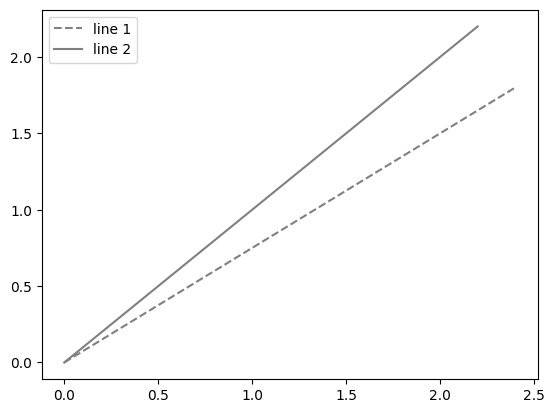

In [69]:
import numpy as np

vector1 = np.array([2.4,1.8])
vector2 = np.array([2.2,2.2])

line1 = np.array([[0,0],vector1])
line2 = np.array([[0,0],vector2])

# plot lines 
plt.plot(line1[:,0], line1[:,1], label = "line 1", color="gray", linestyle='dashed',) 
plt.plot(line2[:,0], line2[:,1], label = "line 2", color="gray") 
plt.legend() 
plt.show()

In [53]:
vector1 @ vector2

9.24

In [75]:
config.seq_len,config.head_size = 24, 2
ROPE = RoPE(config)
x = torch.ones(1,8,config.seq_len,config.head_size)

vector_o1 = np.array([2.4,1.8])
vector_o2 = np.array([2.2,2.2])

x[0,0,1,:] = torch.tensor(vector_o1)
x[0,0,2,:] = torch.tensor(vector_o2)
x[0,0,3,:] = torch.tensor(vector_o1)
x[0,0,4,:] = torch.tensor(vector_o2)
rope = ROPE(x)
rope = rope.squeeze(axis=0)

In [76]:
# plot lines 


vector1 = rope.numpy()[0,1,:]
vector2 = rope.numpy()[0,2,:]

vector3 = rope.numpy()[0,3,:]
vector4 = rope.numpy()[0,4,:]

line1 = np.array([[0,0],vector_o1])
line2 = np.array([[0,0],vector_o2])

q1 = np.array([[0,0],vector1])
k2 = np.array([[0,0],vector2])

q3 = np.array([[0,0],vector3])
k4 = np.array([[0,0],vector4])
# plot lines 


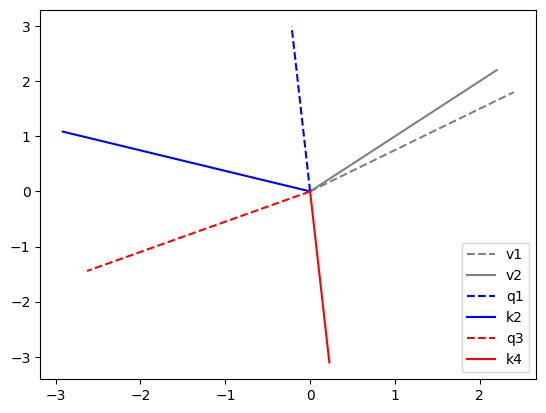

Dot product is: 3.8816514015197754
Dot product is: 3.8816516399383545


In [79]:
plt.plot(line1[:,0], line1[:,1], label = "v1", color="gray", linestyle='dashed',) 
plt.plot(line2[:,0], line2[:,1], label = "v2", color="gray") 

plt.plot(q1[:,0], q1[:,1], label = "q1", color="blue", linestyle='dashed') 
plt.plot(k2[:,0], k2[:,1], label = "k2",  color="blue") 

plt.plot(q3[:,0], q3[:,1], label = "q3", color="red", linestyle='dashed') 
plt.plot(k4[:,0], k4[:,1], label = "k4",  color="red") 

plt.legend()
plt.savefig("generated_texts/2d_vectors3.svg")
plt.show()
print(f"Dot product is: {vector1 @ vector2}")
print(f"Dot product is: {vector3 @ vector4}")

In [80]:
(vector_o1,vector_o2), (vector1, vector2), (vector3, vector4)

((array([2.4, 1.8]), array([2.2, 2.2])),
 (array([-0.21792209,  2.9920745 ], dtype=float32),
  array([-2.9159775,  1.0849314], dtype=float32)),
 (array([-2.629998 , -1.4432985], dtype=float32),
  array([ 0.22694957, -3.1029816 ], dtype=float32)))

### RoPE ones at all positions

In [98]:
config.seq_len,config.head_size = 12, 2
ROPE = RoPE(config)
x = torch.ones(1,8,config.seq_len,config.head_size)
rope = ROPE(x)
rope = rope.squeeze(axis=0)

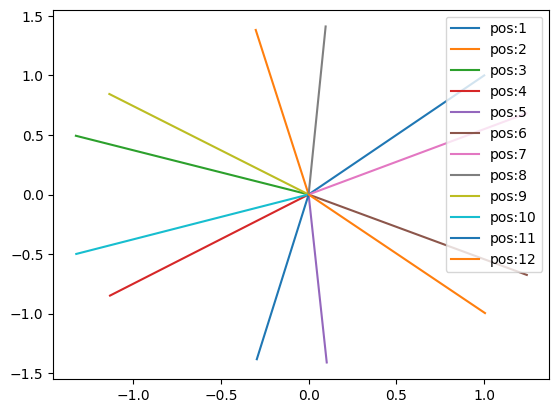

In [101]:
for r in range(rope[0].shape[0]):
    data = np.array([[0,0],rope.numpy()[0,r,:]])    
    plt.plot(data[:,0],data[:,1], label=f"pos:{r+1}")
plt.legend()
plt.savefig("generated_texts/one_rope.svg")
plt.show()


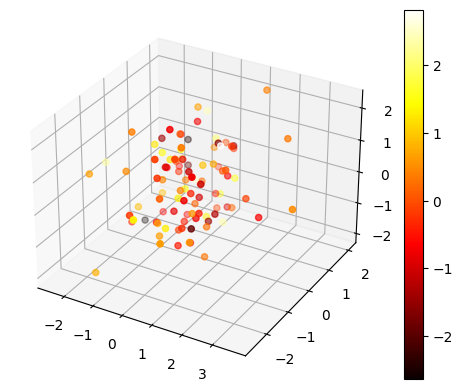

In [100]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.random.standard_normal(100)
y = np.random.standard_normal(100)
z = np.random.standard_normal(100)
c = np.random.standard_normal(100)

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [ ]:

import pandas as pd
import plotly
import plotly.graph_objs as go


#Read cars data from csv
data = pd.read_csv("cars.csv")

#Set marker properties
markercolor = data['city-mpg']

#Make Plotly figure
fig1 = go.Scatter3d(x=data['curb-weight'],
                    y=data['horsepower'],
                    z=data['price'],
                    marker=dict(color=markercolor,
                                opacity=1,
                                reversescale=True,
                                colorscale='Blues',
                                size=5),
                    line=dict (width=0.02),
                    mode='markers')

#Make Plot.ly Layout
mylayout = go.Layout(scene=dict(xaxis=dict( title="curb-weight"),
                                yaxis=dict( title="horsepower"),
                                zaxis=dict(title="price")),)

#Plot and save html
plotly.offline.plot({"data": [fig1],
                     "layout": mylayout},
                     auto_open=True,
                     filename=("4DPlot.html"))

##### Appendex

In [24]:
import plotly.figure_factory as ff

group_labels = ['Group 1', 'Group 2', 'Group 3']
colors = ['#A56CC1', '#A6ACEC', '#63F5EF','#2BCDC1']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([attention_values_1], group_labels = ['distplot'], colors=colors,
                         bin_size=2., show_rug=False, )

# Add title
fig.update_layout(title_text='Hist and Curve Plot',
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  #paper_bgcolor='rgba(0, 0, 0, 0)'
                 )
fig.show()

Mean Attention: 5.716204862986909, Standard deviaiton is: 13.260175106761077


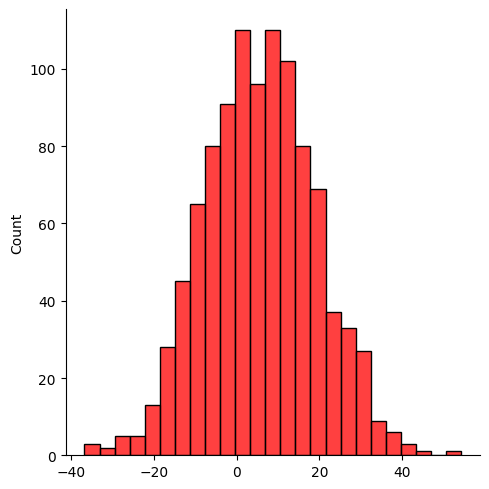

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



print(f"Mean Attention: {np.mean(attention_values_3)}, Standard deviaiton is: {np.std(attention_values_3)}")
# print(f"Standard deviaiton is: {np.std(attention_values_rand_offset)}")


sns.displot(x=attention_values_3,  color = 'red')
plt.show()

# sns.displot(x=attention_values_rand_offset,  color = 'blue')
# plt.show()

Mean Attention: 5.871831136048428, Standard deviaiton is: 13.27090243857343


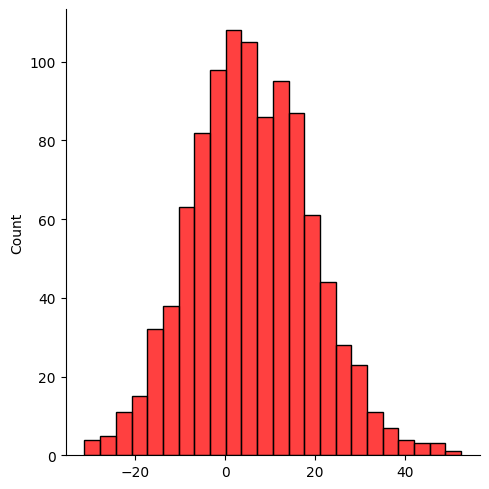

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


print(f"Mean Attention: {np.mean(attention_values_10)}, Standard deviaiton is: {np.std(attention_values_10)}")
# print(f"Standard deviaiton is: {np.std(attention_values_rand_offset)}")


sns.displot(x=attention_values_10,  color = 'red')
plt.show()

# sns.displot(x=attention_values_rand_offset,  color = 'blue')
# plt.show()

Mean Attention: 24.54479637855881, Standard deviaiton is: 2.9085064531941585e-05


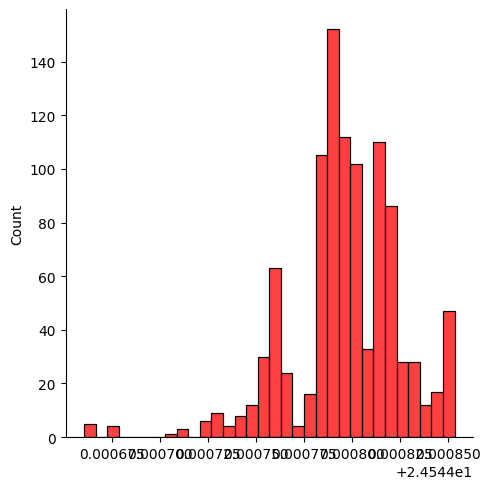

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
print(f"Mean Attention: {np.mean(attention_values_rope_3)}, Standard deviaiton is: {np.std(attention_values_rope_3)}")
#print(f"Mean Attention: {np.mean(attention_values_rand_offset_rope)}, Standard deviaiton is: {np.std(attention_values_rand_offset_rope)}")

sns.displot(x=attention_values_rope_3, color = 'red')
plt.show()

# sns.displot(x=attention_values_rand_offset_rope,  color = 'blue')
# plt.show()

Mean Attention: 23.55476579862675, Standard deviaiton is: 1.7244195253878945e-05


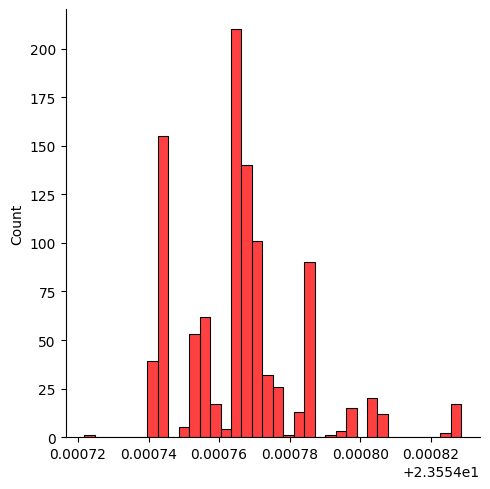

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
print(f"Mean Attention: {np.mean(attention_values_rope_5)}, Standard deviaiton is: {np.std(attention_values_rope_5)}")
#print(f"Mean Attention: {np.mean(attention_values_rand_offset_rope)}, Standard deviaiton is: {np.std(attention_values_rand_offset_rope)}")

sns.displot(x=attention_values_rope_5, color = 'red')
plt.show()

# sns.displot(x=attention_values_rand_offset_rope,  color = 'blue')
# plt.show()

Mean Attention: 20.117853399799657, Standard deviaiton is: 9.698195377502848e-06


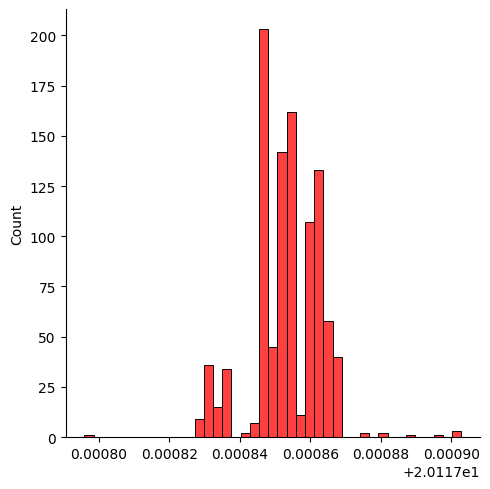

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
print(f"Mean Attention: {np.mean(attention_values_rope_10)}, Standard deviaiton is: {np.std(attention_values_rope_10)}")
#print(f"Mean Attention: {np.mean(attention_values_rand_offset_rope)}, Standard deviaiton is: {np.std(attention_values_rand_offset_rope)}")

sns.displot(x=attention_values_rope_10, color = 'red')
plt.show()

# sns.displot(x=attention_values_rand_offset_rope,  color = 'blue')
# plt.show()

Mean Attention: 16.812139702032294, Standard deviaiton is: 1.6985594839816066e-05


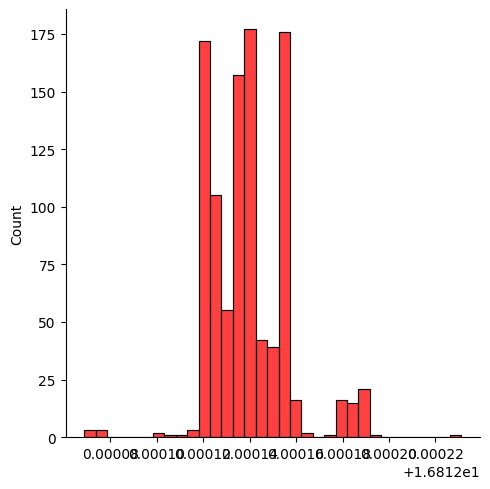

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
print(f"Mean Attention: {np.mean(attention_values_rope_15)}, Standard deviaiton is: {np.std(attention_values_rope_15)}")
#print(f"Mean Attention: {np.mean(attention_values_rand_offset_rope)}, Standard deviaiton is: {np.std(attention_values_rand_offset_rope)}")

sns.displot(x=attention_values_rope_15, color = 'red')
plt.show()

# sns.displot(x=attention_values_rand_offset_rope,  color = 'blue')
# plt.show()

In [38]:
31e-4

0.0031